<a href="https://colab.research.google.com/github/saketkc/pyro-rethinking/blob/master/Chapters/06_Chapter06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 06 - Overfitting, Regularization, and Information Criteria


In [ ]:
!pip install torch torchvision pyro-ppl proplot black blackcellmagic statsmodels patsy

In [ ]:
%load_ext blackcellmagic
import warnings

import pandas as pd
import proplot as plot
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.ops.stats as stats
import pyro.optim
import seaborn as sns
import torch
import torch.distributions.constraints as constraints
import torch.tensor as tensor
from pyro.contrib.autoguide import AutoLaplaceApproximation

warnings.filterwarnings("ignore")
%pylab inline
pyro.set_rng_seed(42)

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

/usr/local/lib/python3.6/dist-packages/proplot/config.py:1454: ProPlotWarning: Rebuilding font cache.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Code 6.1

In [ ]:
import pandas as pd
import torch
import torch.tensor as tensor
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal

sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438., 452., 612., 521., 752., 871., 1350.]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = pd.DataFrame({"species": sppnames, "brain":brainvolcc, "mass": masskg})
brain = tensor(d['brain'], dtype=torch.float)
mass = tensor(d['mass'], dtype=torch.float)


def modelLM(x, y):
  sigma = 1.
  weight = pyro.sample("weight", dist.Normal(0., 100.))
  y_pred = weight * x
  bias = pyro.sample("bias", dist.Normal(x.mean(), 100.))
  y_pred = y_pred + bias
  y = pyro.sample("y", dist.Normal(y_pred, sigma), obs=y)
  return y

adam = pyro.optim.Adam({"lr": 0.03})
guide = AutoDiagonalNormal(modelLM)

svi = SVI(modelLM, guide, adam, loss=Trace_ELBO())
num_iterations = 5000
pyro.clear_param_store()
losses = []
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(mass, brain)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(brain)))
    losses.append(loss)
guide.requires_grad_(False)

guide.quantiles([0.25, 0.5, 0.75])

[iteration 0001] loss: 922617.0140
[iteration 0101] loss: 736301.3414
[iteration 0201] loss: 597407.8432
[iteration 0301] loss: 467509.3486
[iteration 0401] loss: 365105.8928
[iteration 0501] loss: 286934.9869
[iteration 0601] loss: 217594.9398
[iteration 0701] loss: 165312.7858
[iteration 0801] loss: 121732.0647
[iteration 0901] loss: 94113.1033
[iteration 1001] loss: 71102.8468
[iteration 1101] loss: 55977.4891
[iteration 1201] loss: 43756.8428
[iteration 1301] loss: 36727.4556
[iteration 1401] loss: 30650.4078
[iteration 1501] loss: 28724.8164
[iteration 1601] loss: 26610.1936
[iteration 1701] loss: 25622.7252
[iteration 1801] loss: 24928.6907
[iteration 1901] loss: 24721.7366
[iteration 2001] loss: 24464.8411
[iteration 2101] loss: 24283.6640
[iteration 2201] loss: 24243.5505
[iteration 2301] loss: 24215.0529
[iteration 2401] loss: 24222.8154
[iteration 2501] loss: 24209.6450
[iteration 2601] loss: 24212.2392
[iteration 2701] loss: 24212.2720
[iteration 2801] loss: 24206.0991
[iter

{'bias': [tensor(20.3188), tensor(20.4905), tensor(20.6623)],
 'weight': [tensor(15.4664), tensor(15.4902), tensor(15.5140)]}

In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
guide.quantiles([0.25, 0.5, 0.75])

AutoDiagonalNormal.loc Parameter containing:
tensor([ 16.7326, -38.7955])
AutoDiagonalNormal.scale tensor([0.0113, 0.1760])


{'bias': [tensor(-38.9142), tensor(-38.7955), tensor(-38.6767)],
 'weight': [tensor(16.7250), tensor(16.7326), tensor(16.7403)]}

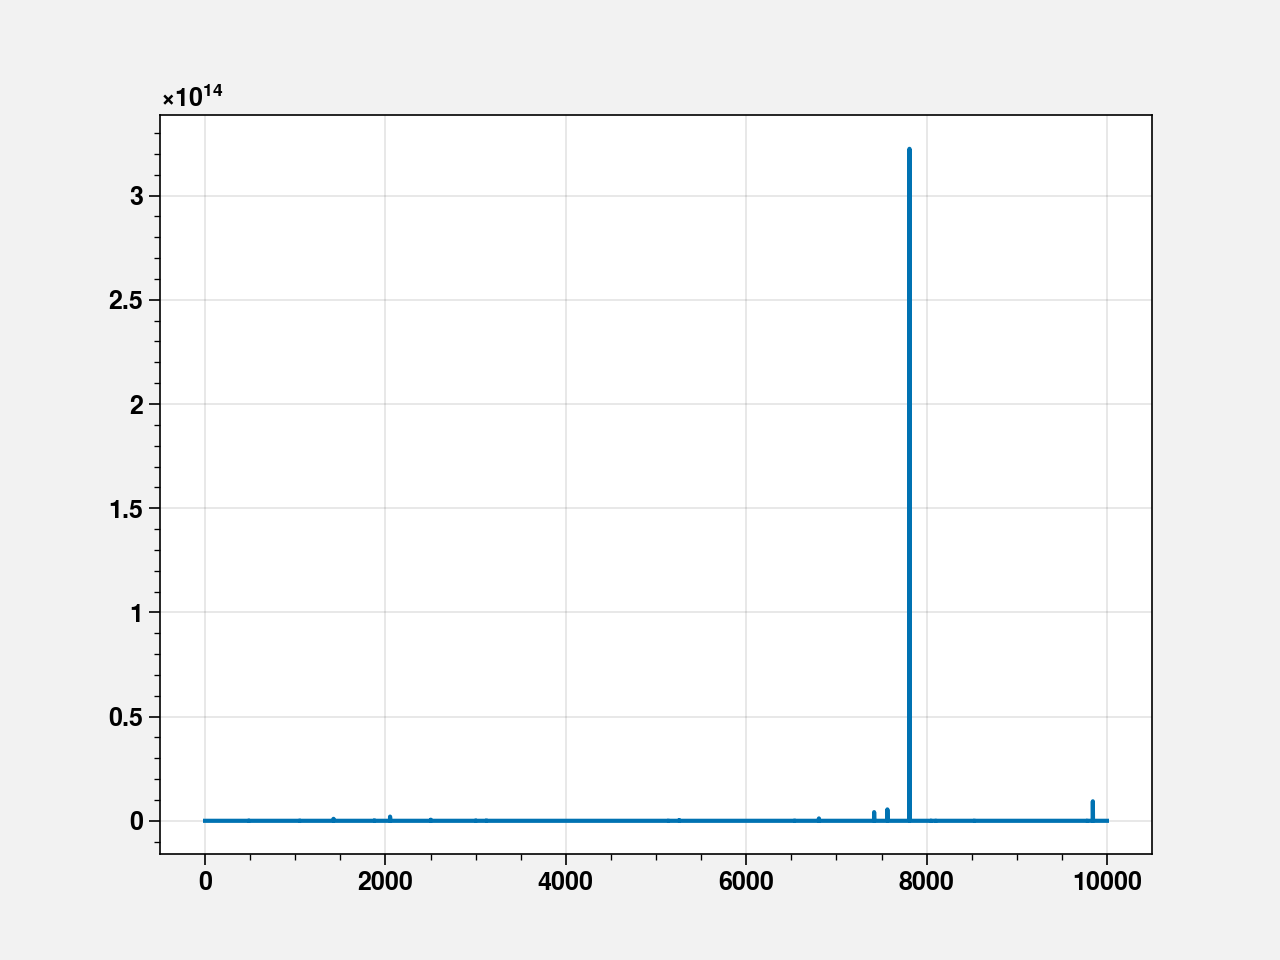

In [ ]:
def modelLM(x, data):
  #sigma = pyro.sample("sigma", dist.HalfCauchy(2.))
  
  sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
  weight = pyro.sample("weight", dist.Normal(0., 1.))
  wx = weight *x 
  #if intercept:
  bias = pyro.sample("bias", dist.Normal(0, 10.))
  wx += bias
  y = pyro.sample("y", dist.Normal(wx, sigma), obs=data)
  return y

def guideLM(x, data):
  mean_weight_param = pyro.param("mean_weight_param", tensor(1.))
  scale_weight_param = pyro.param("scale_weight_param", tensor(1.))
  mean_bias_param = pyro.param("mean_bias_param", x.mean())
  scale_bias_param = pyro.param("scale_bias_param", tensor(20.))
  pyro.sample("weight", dist.Normal(mean_weight_param, scale_weight_param))
  pyro.sample("bias", dist.Normal(mean_bias_param, scale_bias_param))
  #pass
  """
  weight_param = pyro.param("weight_param", tensor(1.)
    )
  bias_param = pyro.param("bias_param", tensor(x.mean())
    )
  sigma_param = pyro.param(
              "sigma_param", tensor(1.), constraint=constraints.positive
    )
  return pyro.sample("weight", dist.Delta(weight_param)), pyro.sample("bias", dist.Delta(bias_param)), pyro.sample("sigma", dist.Delta(sigma_param))
  """


brain = tensor(d['brain'], dtype=torch.float)
mass = tensor(d['mass'], dtype=torch.float)

pyro.clear_param_store()
conditionedLM = pyro.condition(modelLM, data={"y": brain})
svi = pyro.infer.SVI(model=conditionedLM,
                     guide=guideLM,
                     optim=pyro.optim.Adam({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

num_steps = 10000
losses = [svi.step(mass, brain) for t in range(num_steps)]
plt.plot(losses)

[iteration 0001] loss: 233790.9992
[iteration 0101] loss: 54766.2408
[iteration 0201] loss: 26296.1646
[iteration 0301] loss: 25091.1893
[iteration 0401] loss: 25069.8338
[iteration 0501] loss: 25055.3571
[iteration 0601] loss: 25058.1818
[iteration 0701] loss: 25030.7960
[iteration 0801] loss: 25014.5342
[iteration 0901] loss: 24997.5771
[iteration 1001] loss: 24976.4261
[iteration 1101] loss: 24961.4700
[iteration 1201] loss: 24941.4946
[iteration 1301] loss: 24916.0623
[iteration 1401] loss: 24893.0335
[iteration 1501] loss: 24871.4338
[iteration 1601] loss: 24843.1331
[iteration 1701] loss: 24811.1419
[iteration 1801] loss: 24787.4239
[iteration 1901] loss: 24762.4270
[iteration 2001] loss: 24720.0782
[iteration 2101] loss: 24699.4856
[iteration 2201] loss: 24658.9981
[iteration 2301] loss: 24617.8488
[iteration 2401] loss: 24586.5736
[iteration 2501] loss: 24553.2592
[iteration 2601] loss: 24517.7130
[iteration 2701] loss: 24481.6459
[iteration 2801] loss: 24434.6413
[iteration 29

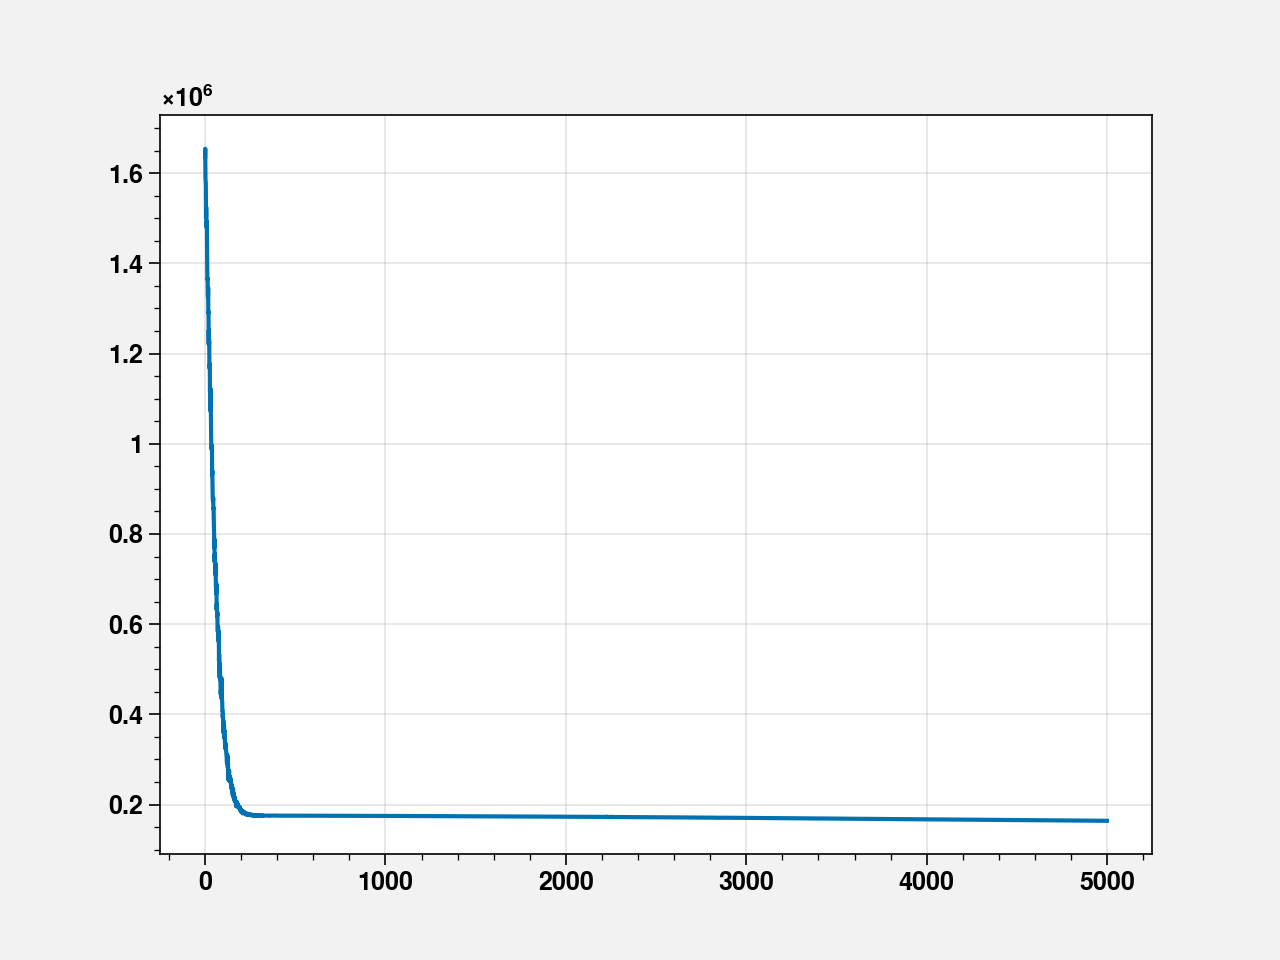

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal

def modelLM(x, data):
  sigma = 1.
  bias = pyro.sample("bias", dist.Normal(x.mean(), 100.))
  weight = pyro.sample("weight", dist.Normal(0., 1.))
  wx = bias + weight * x#(x-x.mean()) 
  y = pyro.sample("y", dist.Normal(wx, sigma), obs=data)
  return wx

brain = tensor(d['brain'], dtype=torch.float)
mass = tensor(d['mass'], dtype=torch.float)

adam = pyro.optim.Adam({"lr": 0.1})
guide = AutoDiagonalNormal(modelLM)

svi = SVI(modelLM, guide, adam, loss=Trace_ELBO())
num_iterations = 5000
pyro.clear_param_store()
losses = []
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(mass, brain)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(brain)))
    losses.append(loss)
plt.plot(losses)

In [ ]:
mass.mean()

tensor(45.5000)

In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
guide.quantiles([0.25, 0.5, 0.75])

AutoDiagonalNormal.loc Parameter containing:
tensor([-51.5508,  16.9979])
AutoDiagonalNormal.scale tensor([0.3538, 0.0114])


{'bias': [tensor(-51.7895), tensor(-51.5508), tensor(-51.3122)],
 'weight': [tensor(16.9902), tensor(16.9979), tensor(17.0056)]}

[iteration 0001] loss: 254845.0785
[iteration 0101] loss: 247055.9115
[iteration 0201] loss: 240495.2820
[iteration 0301] loss: 235000.9384
[iteration 0401] loss: 230403.4633
[iteration 0501] loss: 226542.6376
[iteration 0601] loss: 223270.2866
[iteration 0701] loss: 220453.5194
[iteration 0801] loss: 217977.3062
[iteration 0901] loss: 215746.3029
[iteration 1001] loss: 213685.2439
[iteration 1101] loss: 211737.7946
[iteration 1201] loss: 209864.1515
[iteration 1301] loss: 208037.8542
[iteration 1401] loss: 206242.3825
[iteration 1501] loss: 204468.0775
[iteration 1601] loss: 202709.5810
[iteration 1701] loss: 200964.0997
[iteration 1801] loss: 199230.2607
[iteration 1901] loss: 197507.3608
[iteration 2001] loss: 195795.0999
[iteration 2101] loss: 194093.2430
[iteration 2201] loss: 192401.6750
[iteration 2301] loss: 190720.2237
[iteration 2401] loss: 189048.8570
[iteration 2501] loss: 187387.4702
[iteration 2601] loss: 185735.9752
[iteration 2701] loss: 184094.2119
[iteration 2801] los

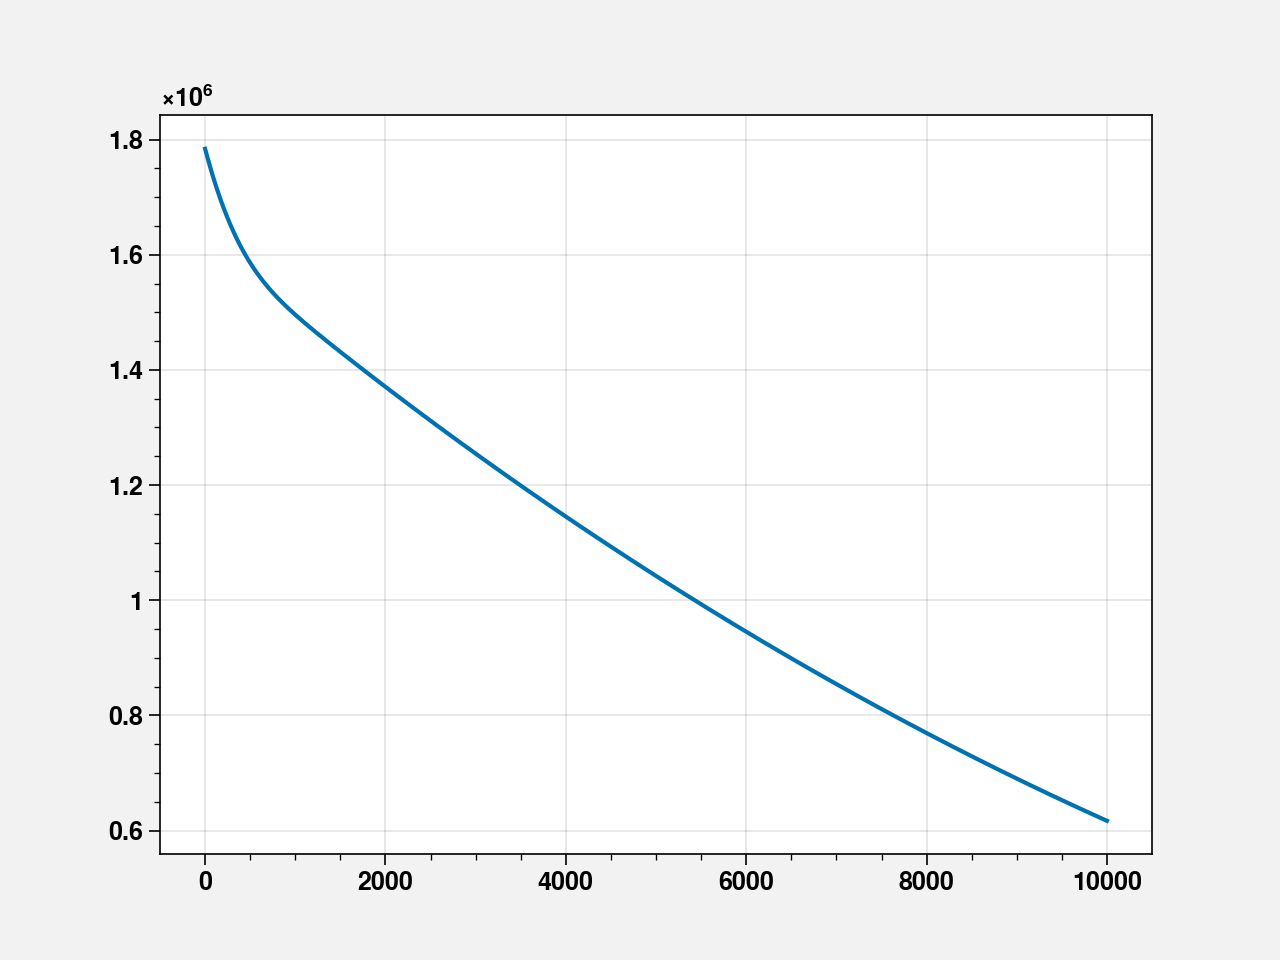

In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
guide.quantiles([0.25, 0.5, 0.75])

AutoLaplaceApproximation.loc Parameter containing:
tensor([ 20.6599, 351.9877])


NotImplementedError: ignored

In [ ]:
from pyro.nn import PyroSample
from torch import nn
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 100.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = 1.#pyro.sample("sigma", dist.Uniform(0., 1.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

brain = tensor(d['brain'], dtype=torch.float).reshape(7,1)
mass = tensor(d['mass'], dtype=torch.float).reshape(7,1)

model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(mass, brain)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(brain)))


[iteration 0001] loss: 2256713.6311
[iteration 0101] loss: 1611672.6334
[iteration 0201] loss: 1152250.9338
[iteration 0301] loss: 823457.5973
[iteration 0401] loss: 638191.6492
[iteration 0501] loss: 517771.8575
[iteration 0601] loss: 456630.1136
[iteration 0701] loss: 425245.6357
[iteration 0801] loss: 409288.2073
[iteration 0901] loss: 400613.0964
[iteration 1001] loss: 397583.8878
[iteration 1101] loss: 396388.7844
[iteration 1201] loss: 395542.3466
[iteration 1301] loss: 395340.0239
[iteration 1401] loss: 395266.2926
[iteration 1501] loss: 395132.2250
[iteration 1601] loss: 395011.0164
[iteration 1701] loss: 394902.2548
[iteration 1801] loss: 394754.8238
[iteration 1901] loss: 394743.1801
[iteration 2001] loss: 394458.3846
[iteration 2101] loss: 394352.4667
[iteration 2201] loss: 394148.2777
[iteration 2301] loss: 393974.8461
[iteration 2401] loss: 393814.8561
[iteration 2501] loss: 393627.5515
[iteration 2601] loss: 393398.9890
[iteration 2701] loss: 393228.6202
[iteration 2801] 

In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
guide.quantiles([0.25, 0.5, 0.75])


AutoDiagonalNormal.loc Parameter containing:
tensor([14.0674, 42.6264])
AutoDiagonalNormal.scale tensor([0.0232, 0.0266])


{'linear.bias': [tensor([42.6085]), tensor([42.6264]), tensor([42.6444])],
 'linear.weight': [tensor([[14.0517]]),
  tensor([[14.0674]]),
  tensor([[14.0830]])]}

In [ ]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

x_data.shape

torch.Size([170, 3])

In [ ]:
mass#.shape

tensor([37.0000, 35.5000, 34.5000, 41.5000, 55.5000, 61.0000, 53.5000])

In [ ]:
brain

tensor([ 438.,  452.,  612.,  521.,  752.,  871., 1350.])

In [ ]:
print("weight = ", pyro.param("mean_weight_param").item())
print("bias = ", pyro.param("mean_bias_param").item())
#print("sigma = ", pyro.param("sigma").item())

weight = pyro.param("mean_weight_param").item()
bias = pyro.param("mean_bias_param").item()
#sigma = pyro.param("sigma_param").item()

y_pred = weight * mass + bias 
resid = brain-y_pred
1-resid.var()/d['brain'].var()

weight =  10.068291664123535
bias =  54.50359344482422


tensor(0.3610)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='brain ~ mass', data=d)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  brain   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Sun, 05 Jul 2020   Prob (F-statistic):             0.0798
Time:                        16:19:05   Log-Likelihood:                -47.462
No. Observations:                   7   AIC:                             98.92
Df Residuals:                       5   BIC:                             98.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -227.6287    439.794     -0.518      0.6